# Simulating the Dynamics of a Volatile Pheromone Field

In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.animation as animation

### Dynamics

The pheromone field follows $$\partial_t c(\vec{x}, t) = k_+ \rho_a(\vec{x},t) - k_-c + D \nabla^2 c$$ where:
- $ c(\vec{x}, t)$: is the concentration of the field at coordinates $\vec{x}$, at time $t$.
- $\rho_a(\vec{x},t)$: Gaussian Kernel convolved over the locations of the ant agents heading back.

#### Implicit Integration

In an implicit scheme, ignoring reinforcement: $$c^{n+1} = c^n + \Delta t(-k_- c^{n+1} + D\nabla^2c^{n+1})$$
and

$$(1+\Delta t k_-) c^{n+1} - D\Delta t\nabla^2c^{n+1} = c^n$$

after discretizing field into a grid and ravelling it into a vector $\vec{c}^n$,

$$((1 +\Delta t k_-) I - D\Delta t L)\vec c^{n+1} = \vec c^n$$

where $I$ is the ientity matrix of appropriate sign and $L$ is the matrix that computes the approximate laplacian with finite differences.

#### Non-Dimensional Quantities:
- Let the $r$ and $v_a$ be the size and speed of the agent respectively.
- $r$ sets the length scale for the simulation and $\tau = r/v_a$ sets the timescale.
- The coordinates $\vec{x}$ can be expressed as $\vec{x} = (u\cdot r, v \cdot r) = r \cdot \vec{u}$; and time as $t = \hat{t}\tau$.

The field dynamics equation now becomes:
$$\frac{v_a}{r} \frac{\partial c}{\partial \hat{t}} = k_+ \rho_a - k_-c + \frac{D}{r^2} \nabla^2 c$$
i.e,
$$\frac{\partial c}{\partial \hat{t}} = \hat{k_+} \rho_a - \hat{k_-}c + \frac{1}{\text{Pe}} \nabla^2 c$$

where $\quad \hat{k_+} = \frac{r k_+}{v_a}, \quad \hat{k_-} = \frac{r k_-}{v_a}, \quad \text{Pe} = \frac{r v_a}{D}$ (the Peclet no.)

In the implementation, we then have:

$$\left( (1 +\Delta \hat t \hat{k_-}) I - \frac{\Delta \hat t}{\text{Pe}} L \right) \vec c^{n+1} = \vec c^n$$

which is of the form $\quad A \ \vec c^{n+1} = \vec c^n$

`scipy`'s linear eqn. solver can then be used to evaluate $c^{n+1}$ given $c^{n}$.

### In Presence of Pher. Generating Agents

The dynamics including the generative term:

$$\frac{\vec c^{n+1}- \vec c^n}{\Delta \hat{t}} = \hat{k_+} \rho_a - \hat{k_-} \vec c + \frac{1}{\text{Pe}} \nabla^2 \vec c$$

$$$$
$$c^{n+1} = c^n + \Delta \hat t \left(\hat{k_+} \rho_a^{n} - \hat{k_-} c^{n+1} + \frac{1}{\text{Pe}}\nabla^2c^{n+1}\right)$$

in the implicit scheme:

$$\left( (1 +\Delta \hat t \hat{k_-}) I - \frac{\Delta \hat t}{\text{Pe}} L \right) \vec c^{n+1} = \vec c^n + \Delta \hat t \hat{k_+} \rho_a^{n}$$


#### Implementation Logistics

For the simulation, we set $r=1$.

Initial conditions $R, w$ (radius and setup of initial semicrcular setup) are expressed relative to the agent size $r$.

The field $c(\vec{u},t)$ is discretized to a grid, $c^t_{ij}$, where the grid spacing in non-dim units is $h$.

In [ ]:
class PheromoneField:
    #Setup
    #---------------------------------------------------------------------------

    def __init__(self, R, h, P, kp, kn, dt):
        """Initialize the PheromoneField class"""
        self.R, self.h  = R, h                    #Radius, Grid spacing
        self.dt = dt                              #Time step size (non-dim units)
        self.Nx, self.Ny = 6*int(R/h), 4*int(R/h) #Grid size
        self.P, self.kn, self.kp = P, kn, kp      #Peclet no., Decay constants (non-dim units)
        self.iters = 0                            #Iteration counter

        self.c = np.zeros((self.Nx, self.Ny))     #Field grid matrix
        x = np.linspace(-3*R, 3*R, self.Nx)
        y = np.linspace(-1*R, 3*R, self.Ny)
        self.X, self.Y = np.meshgrid(x, y, indexing="ij")
        print('Grid set')

        #simulatiton loop variables
        self.cvec = self.c.ravel()                 #convert field matrix to one single vector
        def matvec(v):                             #Matrix-free implicit Diffusion (Laplacian) + Decay operator
            V = v.reshape(self.Nx, self.Ny)
            L = (-4*V +
                 np.roll(V, 1, axis=0) + np.roll(V, -1, axis=0) +
                 np.roll(V, 1, axis=1) + np.roll(V, -1, axis=1)) / self.h**2
            return (1 + self.kn*self.dt)*v - (self.dt/self.P) * L.ravel()
        self.A = spla.LinearOperator((self.Nx*self.Ny, self.Nx*self.Ny), matvec=matvec)

    def set_initial_semicircle(self, R, W):
        """Fill c=1 inside semicircular strip {R-W/2<=r<=R+W/2 && y>=0}"""
        r = np.sqrt(self.X**2 + self.Y**2)
        mask = (self.Y >= 0) & (np.abs(r - R) <= W/2)
        self.c[mask] = 1.0
        self.cvec = self.c.ravel()

    #Simulation loop
    #---------------------------------------------------------------------------
    def step(self, agents, steps):
        """Advance field by dt with implicit diffusion + exact decay."""
        for _ in range(steps):
            dep = self.kp * self.deposit_agents(agents)                             #Pheromone Generation
            self.cvec, _ = spla.cg(self.A, self.cvec, x0=self.cvec, maxiter=200)    #Pheromone Diffusion + Decay
            self.cvec += dep
            for ag in agents:
                ag.step(self.dt)
        self.iters += steps
        return

    def deposit_agents(self, agents, sigma=0.1):
        """Add the pheromones deposit by the agents as gaussians"""
        mask = np.zeros_like(self.cvec.reshape((self.Nx, self.Ny)))
        positions = np.array([ag.r for ag in agents if ag.laying])              #Extract positions of only laying agents
        if len(positions) > 0:
            i = ((positions[:, 0] - self.X.min()) / self.h).astype(int)
            j = ((positions[:, 1] - self.Y.min()) / self.h).astype(int)
            valid = (i >= 0) & (i < self.Nx) & (j >= 0) & (j < self.Ny)
            i, j = i[valid], j[valid]
            np.add.at(mask, (i, j), 1.0)

        deposit = gaussian_filter(mask, sigma/self.h)
        return deposit.ravel()

    #Visualization
    #---------------------------------------------------------------------------
    def animate(self, steps, agents, interval=50):
        """Make a matplotlib animation of the field evolution."""
        self.c = self.cvec.reshape((self.Nx, self.Ny)) #Recover c from cvec

        fig, ax = plt.subplots()
        im = ax.imshow(self.c.T, origin="lower", cmap="viridis", interpolation="nearest",
                       extent=[self.X.min(), self.X.max(),self.Y.min(), self.Y.max()], aspect="equal")
        time_text = ax.text(0.02, 0.95,  f't = 0.00τ', transform=ax.transAxes, color='white')
        ax.set_title("Pheromone field")
        ax.set_xlabel("u")
        ax.set_ylabel("v")

        def update(frame):
            if frame > 0:
                self.step(agents, 1)
            self.c = self.cvec.reshape((self.Nx, self.Ny)) #To recover c from cvec
            im.set_data(self.c.T)
            time_text.set_text(f"t = {self.iters*self.dt:.4f}τ")
            return  im, time_text

        ani = animation.FuncAnimation(fig, update, frames=steps,
                                      interval=interval, blit=True)
        #plt.show()
        return ani

    def plot_frame(self, steps):
        """Make a plot of the field evolution."""
        self.step(agents, steps)
        self.c = self.cvec.reshape((self.Nx, self.Ny)) #To recover c from cvec

        fig, ax = plt.subplots()
        im = ax.imshow(self.c.T, origin="lower", cmap="viridis", vmax=1, vmin=0,
                       extent=[self.X.min(), self.X.max(),self.Y.min(), self.Y.max()], aspect="equal")
        time_text = ax.text(0.02, 0.95,  f't = {self.iters * self.dt:.4f}τ', transform=ax.transAxes, color='white')
        ax.set_title("Pheromone field")
        ax.set_xlabel("u")
        ax.set_ylabel("v")
        plt.show()
        return

In [ ]:
class Agent:
    def __init__(self, r, phat, v=1.0, noise = 0.1, laying=False):
        self.r      = np.array(r, dtype=float)                            #position
        self.phat   = np.array(phat, dtype=float) / np.linalg.norm(phat)  #p_hat: Direction
        self.v      = v                                                   #velocity
        self.laying = laying                                              #is laying pheromones?
        self.noise  = noise                                               #noise level

        self.alpha = 50
        self.tgtphi = 0
        self.thet = 0.5*np.pi
        self.diff = 1.0
        self.tgt = np.array([-10.0,0])

        self.nIntStep = 75
        self.steps = 0
        return

    def step(self, dt):
        if self.steps < self.nIntStep:
            self.intPolicy(dt)
        elif self.steps == self.nIntStep:
            tgtOrn = (self.tgt - self.r)/np.linalg.norm(self.tgt - self.r) #Orientation of the target from given location
            self.tgtphi = np.arctan2(tgtOrn[1], tgtOrn[0])
            self.OUPolicy(dt)
        else:
            self.OUPolicy(dt)
        self.steps += 1
        return

    def intPolicy(self, dt ):
        phi = np.arctan2(self.r[1], self.r[0])
        phi += np.pi/2 + self.noise * np.random.randn()
        self.phat = np.array([np.cos(phi), np.sin(phi)])
        self.r += self.v * dt * self.phat
        return

    def OUPolicy(self, dt):
        self.r += self.v * dt * np.array([np.cos(self.thet), np.sin(self.thet)])
        d_thet = self.alpha*(self.tgtphi - self.thet)*dt + np.sqrt(2*self.diff*dt)*np.random.normal()
        self.thet += d_thet
        return

In [ ]:
agents = [Agent([5,0], [0,1], v=4.0, laying=True),
          Agent([8,0], [0,1], v=6.0, laying=True)]

In [ ]:
field = PheromoneField(R = 10, h=0.1, P=50, kp = 3, kn=0.5, dt=0.01)
field.set_initial_semicircle(R=10, W=0.5)

Grid set


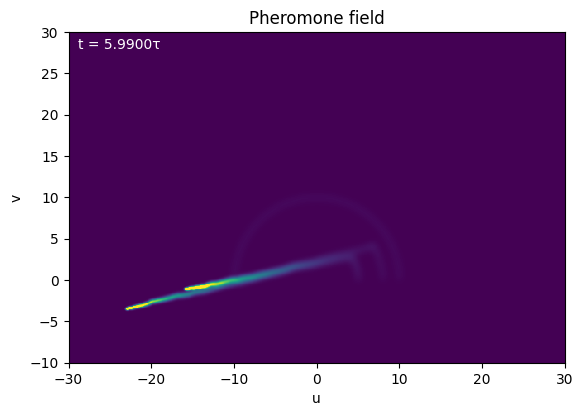

In [ ]:
ani = field.animate(600, agents)
ani.save("pheromone.mp4", writer="ffmpeg", fps=20)